In [1]:
import pandas as pd, numpy as np, re, os
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

# ---- Paths ----
PRED_PATH = "../MentalBert/Output/mentalbert_7labels_predictions.csv"
NRC_PATH  = "../Circumplex Model/NRC-VAD-Lexicon-v2.1/NRC-VAD-Lexicon-v2.1.txt"
OUT_PATH  = "../Circumplex Model/Output/mentalbert_7labels_with_va.csv"

# ---- Load prediction file ----
df = pd.read_csv(PRED_PATH)
print("Columns in CSV:\n", df.columns.tolist()[:15], "...")

# ---- Identify the 7 probability columns ----
# (exclude obvious non-label columns)
non_label_cols = ["subreddit", "title", "clean_text", "url", "labels",  "predicted_emotion", "top3_emotions"]
prob_cols = [c for c in df.columns if c not in non_label_cols]

print(f"✅ Found {len(prob_cols)} emotion-probability columns:")
print(prob_cols)

Columns in CSV:
 ['subreddit', 'title', 'clean_text', 'url', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise', 'predicted_emotion', 'top3_emotions'] ...
✅ Found 7 emotion-probability columns:
['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


In [2]:
import re

def load_nrc_vad(path):
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            parts = re.split(r"[\t, ]+", line.strip())
            if len(parts) < 3 or parts[0].lower() in {"word", "token"}:
                continue
            try:
                word = parts[0].lower()
                val = float(parts[1])
                aro = float(parts[2])
                rows.append((word, val, aro))
            except ValueError:
                continue
    nrc = pd.DataFrame(rows, columns=["word", "valence", "arousal"])
    nrc = nrc.groupby("word", as_index=False).mean()
    return nrc

# ---- Load NRC ----
nrc = load_nrc_vad(NRC_PATH)
print(f"NRC entries loaded: {len(nrc)}")

# ---- Create dictionary for lookup ----
nrc_dict = dict(zip(nrc["word"], zip(nrc["valence"], nrc["arousal"])))

# ---- Map labels ----
labels = [re.sub(r"^prob_", "", c) for c in prob_cols]
V = np.full(len(labels), np.nan)
A = np.full(len(labels), np.nan)

for i, lab in enumerate(labels):
    if lab in nrc_dict:
        V[i], A[i] = nrc_dict[lab]

print(f"Mapped {np.isfinite(V).sum()} / {len(labels)} emotions to NRC terms")

# ---- Weighted valence/arousal for each post ----
P = df[prob_cols].to_numpy(float)
keep = np.isfinite(V)
Pk = P[:, keep]
Vk, Ak = V[keep], A[keep]
wsum = Pk.sum(axis=1, keepdims=True)

valence = (Pk @ Vk) / wsum.ravel()
arousal = (Pk @ Ak) / wsum.ravel()

df["valence"] = valence
df["arousal"] = arousal

print("✅ Added valence and arousal columns to dataframe")
df[["valence", "arousal"]].head()

NRC entries loaded: 44726
Mapped 7 / 7 emotions to NRC terms
✅ Added valence and arousal columns to dataframe


,valence,arousal
0,-0.053029,-0.612822
1,-0.463809,-0.139381
2,-0.022548,-0.518380
3,-0.509850,0.123208
4,-0.059940,-0.625936


In [3]:
# ---- Normalise from [0,1] → [-1,+1] ----
df["valence_norm"] = df["valence"] * 2 - 1
df["arousal_norm"] = df["arousal"] * 2 - 1

# ---- Define quadrant function ----
def quadrant(v, a):
    if np.isnan(v) or np.isnan(a):
        return "NA"
    if v >= 0.5 and a >= 0.5:
        return "Q1: Positive–High Arousal"
    if v >= 0.5 and a < 0.5:
        return "Q2: Positive–Low Arousal"
    if v < 0.5 and a < 0.5:
        return "Q3: Negative–Low Arousal"
    return "Q4: Negative–High Arousal"

# ---- Apply quadrant assignment ----
df["quadrant"] = [quadrant(v, a) for v, a in zip(df["valence"], df["arousal"])]

print(df[["valence", "arousal", "quadrant"]].head())

    valence   arousal                  quadrant
0 -0.053029 -0.612822  Q3: Negative–Low Arousal
1 -0.463809 -0.139381  Q3: Negative–Low Arousal
2 -0.022548 -0.518380  Q3: Negative–Low Arousal
3 -0.509850  0.123208  Q3: Negative–Low Arousal
4 -0.059940 -0.625936  Q3: Negative–Low Arousal


✅ Saved enriched file → ../Circumplex Model/Output/mentalbert_7labels_with_va.csv


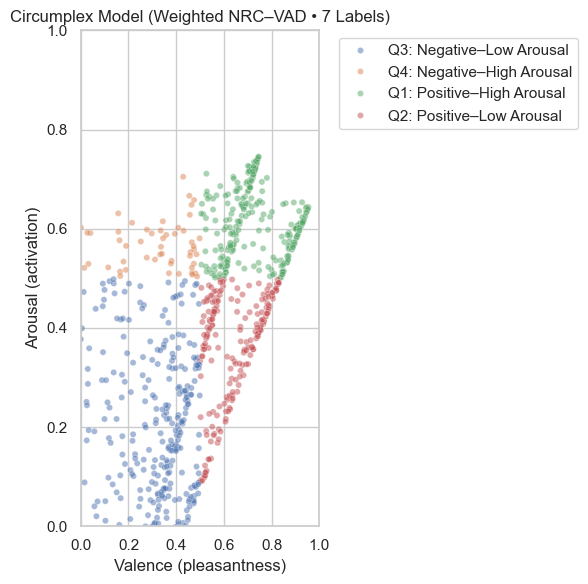

In [4]:
# ---- Save updated dataframe with valence/arousal ----
df.to_csv(OUT_PATH, index=False)
print(f"✅ Saved enriched file → {OUT_PATH}")

# ---- Plot Circumplex Model ----
sns.set(style="whitegrid")

# Subset to valid valence/arousal values
sample = df.dropna(subset=["valence", "arousal"]).sample(min(5000, len(df)), random_state=42)

plt.figure(figsize=(6,6))
sns.scatterplot(
    x="valence", 
    y="arousal", 
    data=sample, 
    hue="quadrant", 
    alpha=0.5, 
    s=20
)

plt.title("Circumplex Model (Weighted NRC–VAD • 7 Labels)")
plt.xlabel("Valence (pleasantness)")
plt.ylabel("Arousal (activation)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()